# Eval trained model

In [1]:
import torch
from torch.utils.data import DataLoader
from dataset import DatasetLandslide
from model import *
import matplotlib.pyplot as plt

model_path = r'../models/unet_vanilla_14b_l4s.ckpt'
model = LandslideModel()
model = LandslideModel.load_from_checkpoint(checkpoint_path=model_path, strict=False)

# data_path = '/home/ryali93/Desktop/landslide4sense2022/ValidData'
# val_dataloader = DatasetLandslide(data_path)
# val_loader = DataLoader(val_dataloader, batch_size=16, shuffle=False)

In [14]:
# 2. Iterar sobre el DataLoader y hacer predicciones
model.eval()  # Poner el modelo en modo evaluación
all_predictions = []

with torch.no_grad():
    for images, _ in val_loader:  # Aquí, estamos desempaquetando las imágenes y las máscaras, pero solo usamos las imágenes
        predictions = model(images)
        # normalize predictions to 0 and 1
        predictions = torch.sigmoid(predictions)
        # convert to numpy array
        predictions = predictions.cpu().numpy()
        all_predictions.append(predictions)

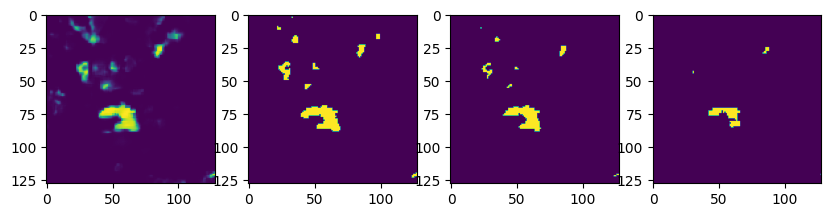

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(10, 10))
ax[0].imshow(all_predictions[11][0][0])
ax[1].imshow(all_predictions[11][0][0] > 0.5)
ax[2].imshow(all_predictions[11][0][0] > 0.7)
ax[3].imshow(all_predictions[11][0][0] > 0.9)
plt.show()

# GEE

In [3]:
import json
import torch
import gcsfs
import numpy as np
import tensorflow as tf
from pprint import pprint
from google.cloud import storage
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from dataset import DatasetLandslide
from model import *
from ee_utils import *

def get_model_pl(model_path):
    model = LandslideModel()
    return  model.load_from_checkpoint(checkpoint_path=model_path)

2023-09-06 18:41:14.464254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 18:41:15.340747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
class TFRecordDataset(Dataset):
    def __init__(self, fileName, side, bands):
        self.fileName = fileName
        self.side = side
        self.bands = bands
        self.featuresDict = {x: tf.io.FixedLenFeature([side, side], dtype=tf.float32) for x in bands}
        
        # Contar el número total de registros en el archivo TFRecord
        self.num_records = sum(1 for _ in tf.data.TFRecordDataset(self.fileName, compression_type='GZIP'))

    def __len__(self):
        return self.num_records

    def __getitem__(self, idx):
        # Crear un iterador que salta hasta el registro deseado y toma uno
        raw_dataset = tf.data.TFRecordDataset(self.fileName, compression_type='GZIP')
        raw_dataset = raw_dataset.skip(idx)
        example = next(iter(raw_dataset.take(1)))
        
        parsed_features = tf.io.parse_single_example(example, self.featuresDict)
        
        # Apilar imágenes
        nfeat = tf.transpose(tf.squeeze(tf.stack(list(parsed_features.values()))))
        nfeat = tf.cast(nfeat, tf.float32)
        nfeat = nfeat.numpy()
        nfeat = np.moveaxis(nfeat, -1, 0)

        nfeat = (nfeat - np.min(nfeat)) / (np.max(nfeat) - np.min(nfeat))
        
        return torch.from_numpy(nfeat)

In [5]:
fileNames = ["/home/ryali93/Downloads/tesis4_ld_6b.tfrecord.gz"]
side = 128
# bands = ["B" + str(x) for x in range(1, 15)]
bands = ["B2","B3","B4","B8","B13","B14"]

In [6]:
dataset = TFRecordDataset(fileNames, side, bands)
dataset_ldr = DataLoader(dataset, batch_size=16, shuffle=False)

2023-09-06 18:41:28.544993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-06 18:41:28.545905: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
import h5py
import numpy as np

def normalize_minmax(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))

image_paths = [r"/home/ryali93/Desktop/l4s/data/TrainData/img/image_1.h5", r"/home/ryali93/Desktop/l4s/data/TrainData/img/point_0450.h5"]
mask_paths = [r"/home/ryali93/Desktop/l4s/data/TrainData/mask/mask_1.h5", r"/home/ryali93/Desktop/l4s/data/TrainData/mask/point_0450.h5"]
with h5py.File(image_paths[1]) as hdf:
    image = np.array(hdf.get('img'))
    # image = image[:, :, [3,2,1]]
    # image = normalize_minmax(image)
    # image = np.moveaxis(image, -1, 0)
with h5py.File(mask_paths[1]) as hdf:
    mask = np.array(hdf.get('mask'))

In [11]:
image.shape

(128, 128, 14)

In [26]:
# save image as tiff with rasterio
import rasterio

# with rasterio.open(r"/tmp/point_0450.tif", 'w', driver='GTiff', height=image.shape[0], width=image.shape[1], count=image.shape[2], dtype=image.dtype) as dst:
#     dst.write(image[:, :, [3,2,1]], indexes=[1,2,3])

# Asumiendo que 'image' es un array 3D con la forma (bands, height, width)
with rasterio.open("/tmp/point_0450.tif", 'w', driver='GTiff',
                   height=image.shape[0], width=image.shape[1],
                   count=image.shape[2], dtype=image.dtype) as dst:
    # Escribir todas las bandas en el archivo
    for i in range(image.shape[2]):
        dst.write(image[:, :, i], indexes=i+1)

/home/ryali93/.local/share/r-miniconda/envs/spatial/lib/python3.8/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


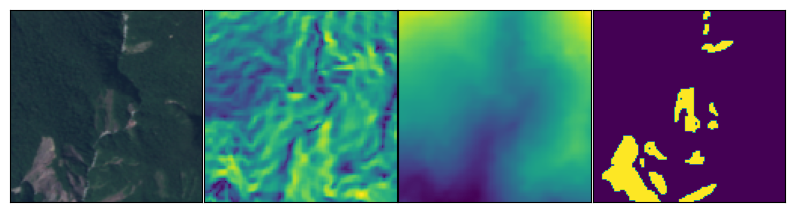

In [71]:
fig, ax = plt.subplots(1, 4, figsize=(10, 10))
ax[0].imshow(image[:, :, [3,2,1]]*1.5)
# ax[1].imshow(image[:, :, 7])
ax[1].imshow(image[:, :, 12])
ax[2].imshow(image[:, :, 13])
ax[3].imshow(mask)
# ax[2].imshow(image*2)
for axi in ax:
    axi.set_xticks([])
    axi.set_yticks([])
fig.subplots_adjust(hspace=0, wspace=0.01)
# remove whitespace from around the image
fig.savefig('/home/ryali93/Desktop/landslide4sense2022/docs/figures/own_450.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [7]:
all_predictions = []
model.eval()
for batch in dataset_ldr:
    with torch.no_grad():
        predictions = model(batch)
        # predictions = torch.sigmoid(predictions)
    all_predictions.append(predictions)
all_predictions = torch.cat(all_predictions)

torch.Size([16, 6, 128, 128])


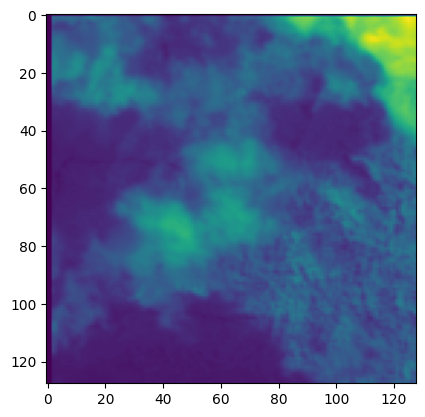

In [19]:
# read the first batch in dataset_ldr
batch = next(iter(dataset_ldr))
print(batch.shape)
# plot the first image in the batch
plt.imshow(batch[0][5])

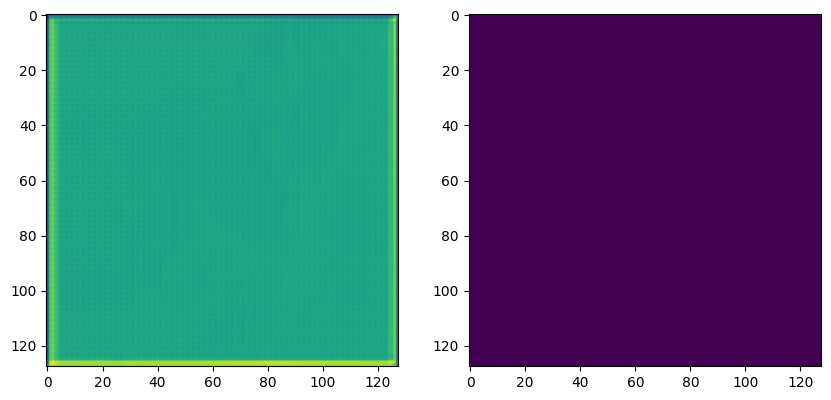

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(all_predictions[5][0])
ax[1].imshow(all_predictions[5][0] <= 0.005)
# ax[2].imshow(all_predictions[8][0] > 0.5)
# ax[3].imshow(all_predictions[8][0] > 0.7)
plt.show()

In [85]:
data_squeezed = all_predictions.squeeze(1)  # Tamaño resultante: [552, 128, 128]
rows = 23  # 3072 / 128
cols = 24  # 2944 / 128
reshaped_data = data_squeezed.view(rows, cols, 128, 128).permute(0, 2, 1, 3).reshape(2944, 3072)

In [35]:
predictions[0]

tensor([[[ -5.3628,  -7.4801,  -7.7412,  ...,  -8.2094,  -8.1291,  -5.6912],
         [ -7.5782,  -9.6271,  -9.9953,  ..., -11.1121, -10.9628,  -8.3033],
         [ -8.5720, -10.8311, -11.4530,  ..., -13.2771, -13.0454,  -9.3436],
         ...,
         [ -7.8358, -10.6753, -11.2029,  ..., -11.3348, -11.0722,  -8.6241],
         [ -7.4519, -10.4351, -11.5886,  ..., -10.6091,  -9.9220,  -7.5369],
         [ -4.7339,  -6.8542,  -7.7124,  ...,  -6.8643,  -6.1831,  -4.6157]]])

In [6]:
import gcsfs

bucket_name = 'rgee_dev'
file_path = 'tesis/ld.tfrecord.gz'

# Inicializar GCSFileSystem
fs = gcsfs.GCSFileSystem()

# Ruta del archivo en GCS
gcs_path = f"gs://{bucket_name}/{file_path}"

# Ruta local donde se guardará el archivo
local_path = "/tmp/ld.tfrecord.gz"

# Descargar el archivo
with fs.open(gcs_path, 'rb') as source:
    with open(local_path, 'wb') as destination:
        destination.write(source.read())

In [7]:
# Parsing the mixer file
fileNames = ["/tmp/ld.tfrecord.gz"]
side = 128
bands = ['B2', 'B3', 'B4', 'B13', 'B14', 'B15']
predict_db = predict_input_fn(fileNames=fileNames, side=side, bands=bands)

In [ ]:
model = get_model_pl("../models/unet_resnet34_b5_r1.ckpt")
predictions = model(predict_db)
print(predictions.shape)

In [ ]:
# torchdata./datapipes.iter.TFRecordLoader(local_path , compression_type='GZIP')
local_path = "/tmp/ld.tfrecord.gz"

In [16]:
# Define la especificación para decodificar el TFRecord
spec = { band: (torch.float32, (side, side)) for band in bands } 
# Aquí, en lugar de usar la ruta de GCS, utiliza el local_path
files_dp = dp.FileLister([local_path])  # Asegúrate de que sea una lista
# Carga y decodifica los TFRecords
tfrecord_dp = dp.TFRecordLoader(files_dp, spec=spec)

In [1]:
import torch
from torch.utils.data import DataLoader
from dataset import DatasetLandslide
from model import *
import matplotlib.pyplot as plt

model_path = r'../models/unet_resnet34_14b_l4s.ckpt'
model = LandslideModel()
model = LandslideModel.load_from_checkpoint(checkpoint_path=model_path, strict=False)

data_path = '/home/ryali93/Desktop/l4s/data/TrainData'
train_dataloader = DatasetLandslide(data_path)
train_loader = DataLoader(train_dataloader, batch_size=16, shuffle=False)

# 2. Iterar sobre el DataLoader y hacer predicciones
model.eval()  # Poner el modelo en modo evaluación
all_predictions = []
all_images = []
all_gt = []
i = 0

with torch.no_grad():
    for images, _ in train_loader:  # Aquí, estamos desempaquetando las imágenes y las máscaras, pero solo usamos las imágenes
        all_images.append(images)
        all_gt.append(_)
        predictions = model(images)
        # normalize predictions to 0 and 1
        # predictions = torch.sigmoid(predictions)
        predictions = predictions.cpu().numpy()
        all_predictions.append(predictions)
        i += 1
        if i == 10:
            break

FileNotFoundError: [Errno 2] No such file or directory: '/home/ryali93/Desktop/l4s/scripts/../models/unet_resnet34_14b_l4s_2.ckpt'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


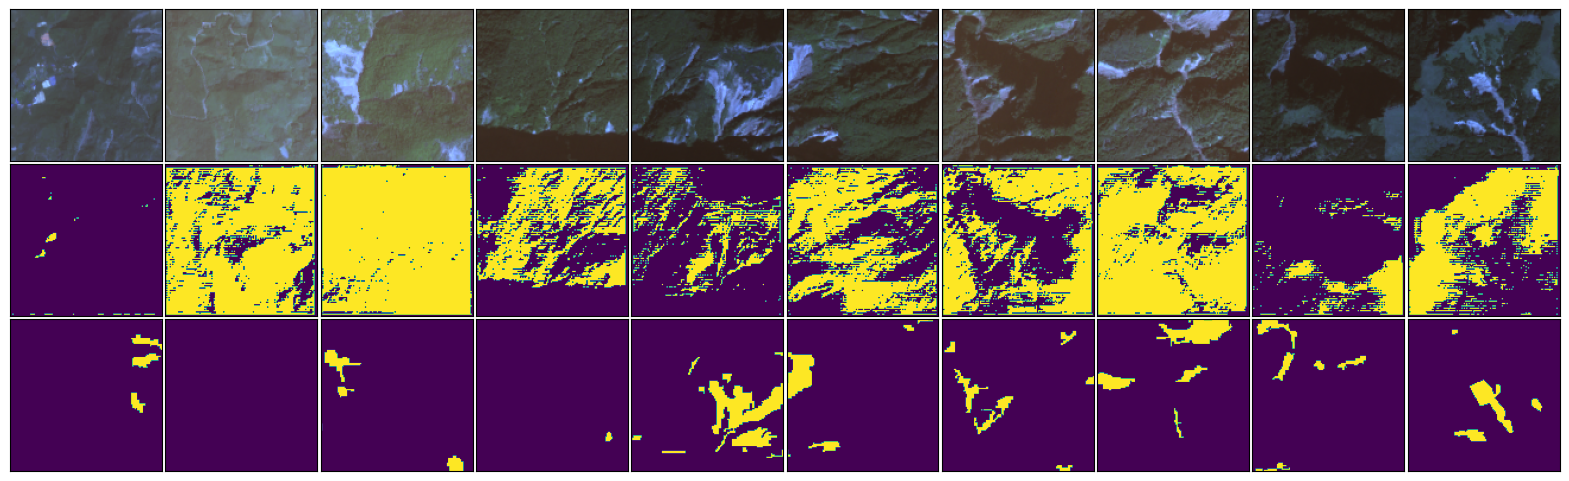

In [15]:
# Crear una gráfica con la imagen, el ground truth, y la predicción para la primera imagen en el lote, para cada modelo
fig, ax = plt.subplots(3, 10, figsize=(20, 6))

for i in range(10):
    ax[0, i].imshow(all_images[0][i][1:4].permute(1, 2, 0)*1.5)
    ax[1, i].imshow(all_predictions[0][i][0] < 0.516)
    ax[2, i].imshow(all_gt[0][i][0])

    # remove axis
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
    ax[2, i].set_xticks([])
    ax[2, i].set_yticks([])

fig.subplots_adjust(hspace=0.02, wspace=0.02)
# fig.savefig('/home/ryali93/Desktop/landslide4sense2022/docs/figures_n/unet_vanilla_14b_l4s.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
# fig.savefig('/home/ryali93/Desktop/landslide4sense2022/docs/figures_n/point_3_2.png', bbox_inches='tight', pad_inches=0)

In [13]:
# get all namefiles from path
import os
import glob

path = r'/home/ryali93/Desktop/landslide4sense2022/docs/figures_n'
all_files = glob.glob(os.path.join(path, "*.png"))
all_files.sort()

In [14]:
all_files

['/home/ryali93/Desktop/landslide4sense2022/docs/figures_n/point_3_2.png',
 '/home/ryali93/Desktop/landslide4sense2022/docs/figures_n/point_3_9.png',
 '/home/ryali93/Desktop/landslide4sense2022/docs/figures_n/point_5_1.png',
 '/home/ryali93/Desktop/landslide4sense2022/docs/figures_n/unet_mobilenetv2_14b_full.png',
 '/home/ryali93/Desktop/landslide4sense2022/docs/figures_n/unet_mobilenetv2_14b_l4s.png',
 '/home/ryali93/Desktop/landslide4sense2022/docs/figures_n/unet_mobilenetv2_6b_full.png',
 '/home/ryali93/Desktop/landslide4sense2022/docs/figures_n/unet_resnet34_14b_l4s.png',
 '/home/ryali93/Desktop/landslide4sense2022/docs/figures_n/unet_resnet34_6b_full.png',
 '/home/ryali93/Desktop/landslide4sense2022/docs/figures_n/unet_segformer1_14b_full.png',
 '/home/ryali93/Desktop/landslide4sense2022/docs/figures_n/unet_segformer1_14b_l4s.png',
 '/home/ryali93/Desktop/landslide4sense2022/docs/figures_n/unet_segformer1_6b_full.png',
 '/home/ryali93/Desktop/landslide4sense2022/docs/figures_n/une